In [1]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")
print(f"NumPy version: {np.__version__}")

Libraries imported successfully!
NumPy version: 2.1.3


In [5]:
def load_images(folder_path, target_size=(32, 32)):
    images = []
    labels = []
    class_names = []
    
    try:
        class_folders = sorted([f for f in os.listdir(folder_path) 
                               if os.path.isdir(os.path.join(folder_path, f))])
        
        print(f"Found {len(class_folders)} classes: {class_folders}")
        
        for class_idx, class_name in enumerate(class_folders):
            class_names.append(class_name)
            class_path = os.path.join(folder_path, class_name)
            image_files = [f for f in os.listdir(class_path) 
                          if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))]
            
            print(f"Loading {len(image_files)} images from class '{class_name}'...")
            
            for img_file in tqdm(image_files, desc=f"Class {class_name}"):
                try:
                    img_path = os.path.join(class_path, img_file)
                    img = Image.open(img_path)
                    img = img.convert('L')
                    img = img.resize(target_size)
                    img_array = np.array(img)
                    # if normalize:
                    #     img_array = img_array / 255.0
                    
                    images.append(img_array)
                    labels.append(class_idx)
                    
                except Exception as e:
                    print(f"Error loading {img_file}: {str(e)}")
                    continue
        
        images = np.array(images)
        labels = np.array(labels)
        
        print(f"\nDataset loaded successfully!")
        print(f"Total images: {len(images)}")
        print(f"Image shape: {images[0].shape}")
        print(f"Classes: {class_names}")
        print(f"Class distribution: {np.bincount(labels)}")
        
        return images, labels, class_names
    
    except Exception as e:
        print(f"Error in load_images_from_folder: {str(e)}")
        return None, None, None

DATASET_PATH = "./animal_dataset"
images, labels, class_names = load_images(DATASET_PATH)

Found 3 classes: ['cat', 'dog', 'panda']
Loading 100 images from class 'cat'...


Class cat: 100%|██████████| 100/100 [00:00<00:00, 164.84it/s]


Loading 100 images from class 'dog'...


Class dog: 100%|██████████| 100/100 [00:01<00:00, 97.82it/s]


Loading 100 images from class 'panda'...


Class panda: 100%|██████████| 100/100 [00:01<00:00, 92.22it/s]


Dataset loaded successfully!
Total images: 300
Image shape: (32, 32)
Classes: ['cat', 'dog', 'panda']
Class distribution: [100 100 100]


# Data Visualization

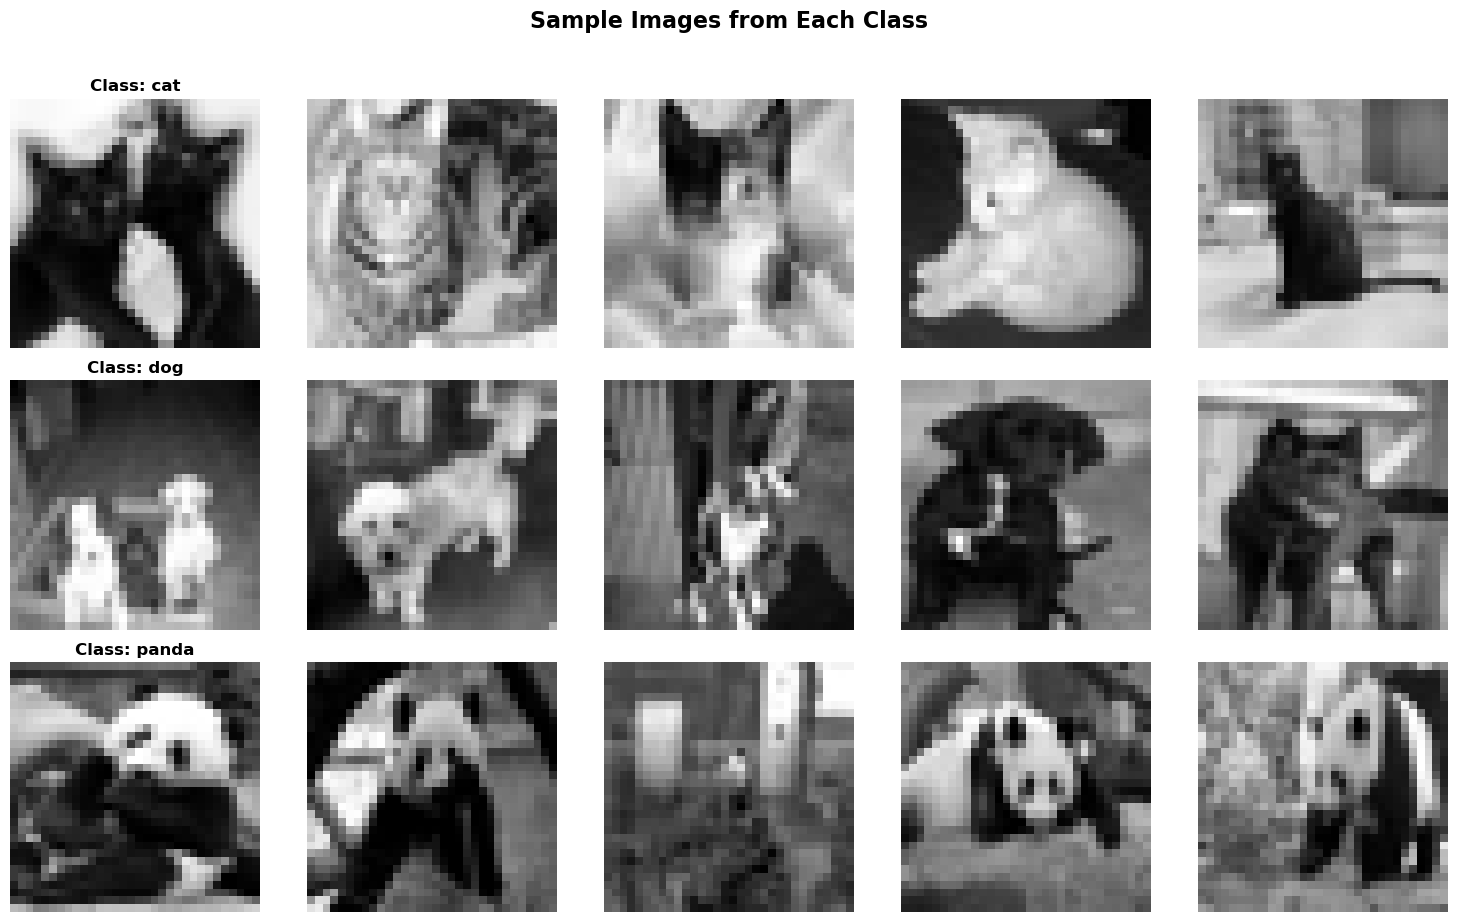

In [7]:
def visualizeSamples(images, labels, class_names, samples_per_class=5):
    n_classes = len(class_names)
    fig, axes = plt.subplots(n_classes, samples_per_class, 
                            figsize=(15, 3 * n_classes))
    
    if n_classes == 1:
        axes = axes.reshape(1, -1)
    
    for class_idx in range(n_classes):
        class_indices = np.where(labels == class_idx)[0]
        sample_indices = np.random.choice(class_indices, 
                                         min(samples_per_class, len(class_indices)), 
                                         replace=False)
        
        for i, idx in enumerate(sample_indices):
            axes[class_idx, i].imshow(images[idx], cmap='gray')
            axes[class_idx, i].axis('off')
            if i == 0:
                axes[class_idx, i].set_title(f"Class: {class_names[class_idx]}", 
                                            fontsize=12, fontweight='bold')
    
    plt.suptitle('Sample Images from Each Class', fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

visualizeSamples(images, labels, class_names)

# Data Preprocessing

In [8]:
def preprocessImages(images):
    n_samples = images.shape[0]
    flattened = images.reshape(n_samples, -1)
    flattened = flattened.astype(np.float32) / 255.0
    
    print(f"Original shape: {images.shape}")
    print(f"Flattened shape: {flattened.shape}")
    print(f"Value range: [{flattened.min():.3f}, {flattened.max():.3f}]")
    return flattened

X = preprocessImages(images)
y = labels

print(f"\nFinal dataset shape: X={X.shape}, y={y.shape}")

Original shape: (300, 32, 32)
Flattened shape: (300, 1024)
Value range: [0.000, 1.000]

Final dataset shape: X=(300, 1024), y=(300,)


# Distance Calc

In [9]:
def manhattan_distance(x1, x2):
    return np.sum(np.abs(x1 - x2))

def euclidean_distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2) ** 2))

test_x1 = np.array([1.0, 2.0, 3.0])
test_x2 = np.array([4.0, 5.0, 6.0])

print("Distance Function Tests:")
print(f"Test vectors: x1={test_x1}, x2={test_x2}")
print(f"Manhattan distance: {manhattan_distance(test_x1, test_x2):.4f}")
print(f"Euclidean distance: {euclidean_distance(test_x1, test_x2):.4f}")

Distance Function Tests:
Test vectors: x1=[1. 2. 3.], x2=[4. 5. 6.]
Manhattan distance: 9.0000
Euclidean distance: 5.1962


# K-Nearest Neighbors Classifiers

In [10]:
class KNNClassifier:
    def __init__(self, k=3, distance_metric='euclidean'):
        self.k = k
        self.distance_metric = distance_metric
        self.X_train = None
        self.y_train = None
    
    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train
    
    def predict(self, X_test, show_progress=False):
        predictions = []   
        iterator = tqdm(X_test, desc="Predicting") if show_progress else X_test       
        for test_sample in iterator:
            distances = []
            
            for train_sample in self.X_train:
                if self.distance_metric == 'manhattan':
                    dist = manhattan_distance(test_sample, train_sample)
                elif self.distance_metric == 'euclidean':
                    dist = euclidean_distance(test_sample, train_sample)
                else:
                    raise ValueError("Distance metric must be 'manhattan' or 'euclidean'")
                
                distances.append(dist)
            
            distances = np.array(distances)
            k_nearest_indices = np.argsort(distances)[:self.k]
            k_nearest_labels = self.y_train[k_nearest_indices]
            prediction = self._majority_vote(k_nearest_labels)
            predictions.append(prediction)
        
        return np.array(predictions)
    
    def _majority_vote(self, labels):
        unique_labels, counts = np.unique(labels, return_counts=True)
        max_count_idx = np.argmax(counts)
        return unique_labels[max_count_idx]

print("KNN Classifier class defined successfully!")

KNN Classifier class defined successfully!


# K-Fold Cross Validation

In [11]:
def create_k_folds(X, y, n_folds=5, shuffle=True, random_seed=42):
    n_samples = X.shape[0]
    indices = np.arange(n_samples)    
    if shuffle:
        np.random.seed(random_seed)
        np.random.shuffle(indices)
    
    fold_sizes = np.full(n_folds, n_samples // n_folds, dtype=int)
    fold_sizes[:n_samples % n_folds] += 1    
    folds = []
    current = 0    
    for fold_size in fold_sizes:
        val_indices = indices[current:current + fold_size]
        train_indices = np.concatenate([indices[:current], indices[current + fold_size:]])
        folds.append((train_indices, val_indices))
        current += fold_size
    
    print(f"Created {n_folds} folds:")
    for i, (train_idx, val_idx) in enumerate(folds):
        print(f"  Fold {i+1}: Train={len(train_idx)}, Val={len(val_idx)}")
    
    return folds

folds = create_k_folds(X, y, n_folds=5, shuffle=True)

Created 5 folds:
  Fold 1: Train=240, Val=60
  Fold 2: Train=240, Val=60
  Fold 3: Train=240, Val=60
  Fold 4: Train=240, Val=60
  Fold 5: Train=240, Val=60


# Accuracy Calc

In [12]:
def calculate_accuracy(y_true, y_pred):
    correct = np.sum(y_true == y_pred)
    total = len(y_true)
    accuracy = correct / total
    return accuracy

def calculate_confusion_matrix(y_true, y_pred, n_classes):
    cm = np.zeros((n_classes, n_classes), dtype=int)    
    for true_label, pred_label in zip(y_true, y_pred):
        cm[true_label, pred_label] += 1
    
    return cm
print("Accuracy calculation functions defined successfully!")

Accuracy calculation functions defined successfully!


# Cross Validation

In [13]:
def cross_validate_knn(X, y, k_values, folds, distance_metric='euclidean'):
    results = {k: [] for k in k_values}    
    print(f"\n{'='*80}")
    print(f"Cross-Validation with {distance_metric.upper()} distance")
    print(f"{'='*80}\n")
    
    for fold_idx, (train_indices, val_indices) in enumerate(folds):
        print(f"\n--- Fold {fold_idx + 1}/{len(folds)} ---")
        X_train, X_val = X[train_indices], X[val_indices]
        y_train, y_val = y[train_indices], y[val_indices]      
        print(f"Train size: {len(X_train)}, Validation size: {len(X_val)}")
        
        for k in tqdm(k_values, desc=f"Testing K values"):
            try:
                knn = KNNClassifier(k=k, distance_metric=distance_metric)
                knn.fit(X_train, y_train)
                y_pred = knn.predict(X_val, show_progress=False)
                accuracy = calculate_accuracy(y_val, y_pred)
                results[k].append(accuracy)
                
            except Exception as e:
                print(f"\nError with k={k} in fold {fold_idx + 1}: {str(e)}")
                results[k].append(0.0)
        
        print(f"\nFold {fold_idx + 1} Results:")
        for k in k_values[:5]: 
            avg_acc = np.mean(results[k][:fold_idx + 1])
            print(f"  k={k}: Accuracy = {results[k][fold_idx]:.4f} (Avg so far: {avg_acc:.4f})")
    
    return results

k_values = list(range(1, 31, 2))
print(f"Testing K values: {k_values}")

Testing K values: [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29]


# Cross Validation for Manhattan

In [ ]:
print("TRAINING WITH MANHATTAN (L1) DISTANCE")
results_manhattan = cross_validate_knn(X, y, k_values, folds, distance_metric='manhattan')
avg_accuracies_manhattan = {k: np.mean(accuracies) 
                            for k, accuracies in results_manhattan.items()}

print(f"\n{'='*80}")
print("MANHATTAN DISTANCE - AVERAGE ACCURACIES ACROSS ALL FOLDS")
print(f"{'='*80}\n")
print(f"{'K Value':<10} {'Avg Accuracy':<15} {'Std Dev':<15}")
print("-" * 40)
for k in k_values:
    avg_acc = avg_accuracies_manhattan[k]
    std_acc = np.std(results_manhattan[k])
    print(f"{k:<10} {avg_acc:<15.4f} {std_acc:<15.4f}")

best_k_manhattan = max(avg_accuracies_manhattan, key=avg_accuracies_manhattan.get)
best_acc_manhattan = avg_accuracies_manhattan[best_k_manhattan]
print(f"\nBest K for Manhattan: {best_k_manhattan} with accuracy: {best_acc_manhattan:.4f}")

TRAINING WITH MANHATTAN (L1) DISTANCE

Cross-Validation with MANHATTAN distance


--- Fold 1/5 ---
Train size: 240, Validation size: 60


Testing K values: 100%|██████████| 15/15 [00:04<00:00,  3.40it/s]



Fold 1 Results:
  k=1: Accuracy = 0.4167 (Avg so far: 0.4167)
  k=3: Accuracy = 0.3333 (Avg so far: 0.3333)
  k=5: Accuracy = 0.3667 (Avg so far: 0.3667)
  k=7: Accuracy = 0.3667 (Avg so far: 0.3667)
  k=9: Accuracy = 0.3667 (Avg so far: 0.3667)

--- Fold 2/5 ---
Train size: 240, Validation size: 60


Testing K values: 100%|██████████| 15/15 [00:04<00:00,  3.42it/s]



Fold 2 Results:
  k=1: Accuracy = 0.3500 (Avg so far: 0.3833)
  k=3: Accuracy = 0.4667 (Avg so far: 0.4000)
  k=5: Accuracy = 0.4500 (Avg so far: 0.4083)
  k=7: Accuracy = 0.4167 (Avg so far: 0.3917)
  k=9: Accuracy = 0.4500 (Avg so far: 0.4083)

--- Fold 3/5 ---
Train size: 240, Validation size: 60


Testing K values: 100%|██████████| 15/15 [00:04<00:00,  3.56it/s]



Fold 3 Results:
  k=1: Accuracy = 0.4500 (Avg so far: 0.4056)
  k=3: Accuracy = 0.4167 (Avg so far: 0.4056)
  k=5: Accuracy = 0.4167 (Avg so far: 0.4111)
  k=7: Accuracy = 0.4167 (Avg so far: 0.4000)
  k=9: Accuracy = 0.4167 (Avg so far: 0.4111)

--- Fold 4/5 ---
Train size: 240, Validation size: 60


Testing K values: 100%|██████████| 15/15 [00:03<00:00,  3.96it/s]



Fold 4 Results:
  k=1: Accuracy = 0.2667 (Avg so far: 0.3708)
  k=3: Accuracy = 0.3833 (Avg so far: 0.4000)
  k=5: Accuracy = 0.4500 (Avg so far: 0.4208)
  k=7: Accuracy = 0.3667 (Avg so far: 0.3917)
  k=9: Accuracy = 0.3833 (Avg so far: 0.4042)

--- Fold 5/5 ---
Train size: 240, Validation size: 60


Testing K values: 100%|██████████| 15/15 [00:03<00:00,  4.15it/s]


Fold 5 Results:
  k=1: Accuracy = 0.5000 (Avg so far: 0.3967)
  k=3: Accuracy = 0.4000 (Avg so far: 0.4000)
  k=5: Accuracy = 0.3667 (Avg so far: 0.4100)
  k=7: Accuracy = 0.4500 (Avg so far: 0.4033)
  k=9: Accuracy = 0.4333 (Avg so far: 0.4100)

MANHATTAN DISTANCE - AVERAGE ACCURACIES ACROSS ALL FOLDS

K Value    Avg Accuracy    Std Dev        
----------------------------------------
1          0.3967          0.0812         
3          0.4000          0.0435         
5          0.4100          0.0374         
7          0.4033          0.0323         
9          0.4100          0.0309         
11         0.4467          0.0552         
13         0.4633          0.0600         
15         0.4500          0.0723         
17         0.4200          0.0645         
19         0.4033          0.0636         
21         0.4467          0.0878         
23         0.4433          0.0892         
25         0.4433          0.0847         
27         0.4167          0.0723         
29      

# Cross Validation for Euclidean

In [15]:
print("TRAINING WITH EUCLIDEAN (L2) DISTANCE")
resultsEuclidean = cross_validate_knn(X, y, k_values, folds, distance_metric='euclidean')
avgAccuraciesEuclidean = {k: np.mean(accuracies) 
                           for k, accuracies in resultsEuclidean.items()}

print(f"\n{'='*80}")
print("EUCLIDEAN DISTANCE - AVERAGE ACCURACIES ACROSS ALL FOLDS")
print(f"{'='*80}\n")
print(f"{'K Value':<10} {'Avg Accuracy':<15} {'Std Dev':<15}")
print("-" * 40)
for k in k_values:
    avg_acc = avgAccuraciesEuclidean[k]
    std_acc = np.std(resultsEuclidean[k])
    print(f"{k:<10} {avg_acc:<15.4f} {std_acc:<15.4f}")

best_k_euclidean = max(avgAccuraciesEuclidean, key=avgAccuraciesEuclidean.get)
best_acc_euclidean = avgAccuraciesEuclidean[best_k_euclidean]
print(f"\nBest K for Euclidean: {best_k_euclidean} with accuracy: {best_acc_euclidean:.4f}")

TRAINING WITH EUCLIDEAN (L2) DISTANCE

Cross-Validation with EUCLIDEAN distance


--- Fold 1/5 ---
Train size: 240, Validation size: 60


Testing K values: 100%|██████████| 15/15 [00:05<00:00,  2.93it/s]



Fold 1 Results:
  k=1: Accuracy = 0.3333 (Avg so far: 0.3333)
  k=3: Accuracy = 0.3000 (Avg so far: 0.3000)
  k=5: Accuracy = 0.3000 (Avg so far: 0.3000)
  k=7: Accuracy = 0.3667 (Avg so far: 0.3667)
  k=9: Accuracy = 0.4000 (Avg so far: 0.4000)

--- Fold 2/5 ---
Train size: 240, Validation size: 60


Testing K values: 100%|██████████| 15/15 [00:05<00:00,  2.76it/s]



Fold 2 Results:
  k=1: Accuracy = 0.3167 (Avg so far: 0.3250)
  k=3: Accuracy = 0.4500 (Avg so far: 0.3750)
  k=5: Accuracy = 0.4333 (Avg so far: 0.3667)
  k=7: Accuracy = 0.4167 (Avg so far: 0.3917)
  k=9: Accuracy = 0.4167 (Avg so far: 0.4083)

--- Fold 3/5 ---
Train size: 240, Validation size: 60


Testing K values: 100%|██████████| 15/15 [00:05<00:00,  2.55it/s]



Fold 3 Results:
  k=1: Accuracy = 0.4833 (Avg so far: 0.3778)
  k=3: Accuracy = 0.4000 (Avg so far: 0.3833)
  k=5: Accuracy = 0.4500 (Avg so far: 0.3944)
  k=7: Accuracy = 0.4167 (Avg so far: 0.4000)
  k=9: Accuracy = 0.4167 (Avg so far: 0.4111)

--- Fold 4/5 ---
Train size: 240, Validation size: 60


Testing K values: 100%|██████████| 15/15 [00:05<00:00,  2.68it/s]



Fold 4 Results:
  k=1: Accuracy = 0.2167 (Avg so far: 0.3375)
  k=3: Accuracy = 0.3500 (Avg so far: 0.3750)
  k=5: Accuracy = 0.3500 (Avg so far: 0.3833)
  k=7: Accuracy = 0.2667 (Avg so far: 0.3667)
  k=9: Accuracy = 0.2833 (Avg so far: 0.3792)

--- Fold 5/5 ---
Train size: 240, Validation size: 60


Testing K values: 100%|██████████| 15/15 [00:05<00:00,  2.63it/s]


Fold 5 Results:
  k=1: Accuracy = 0.5333 (Avg so far: 0.3767)
  k=3: Accuracy = 0.3833 (Avg so far: 0.3767)
  k=5: Accuracy = 0.3500 (Avg so far: 0.3767)
  k=7: Accuracy = 0.4333 (Avg so far: 0.3800)
  k=9: Accuracy = 0.3833 (Avg so far: 0.3800)

EUCLIDEAN DISTANCE - AVERAGE ACCURACIES ACROSS ALL FOLDS

K Value    Avg Accuracy    Std Dev        
----------------------------------------
1          0.3767          0.1158         
3          0.3767          0.0501         
5          0.3767          0.0564         
7          0.3800          0.0609         
9          0.3800          0.0499         
11         0.4000          0.0506         
13         0.3867          0.0499         
15         0.3967          0.0510         
17         0.4033          0.0464         
19         0.4000          0.0471         
21         0.4000          0.0506         
23         0.3967          0.0542         
25         0.3900          0.0523         
27         0.3667          0.0483         
29      

# Comparison Plot

Plot saved as 'knn_comparison_detailed.png'


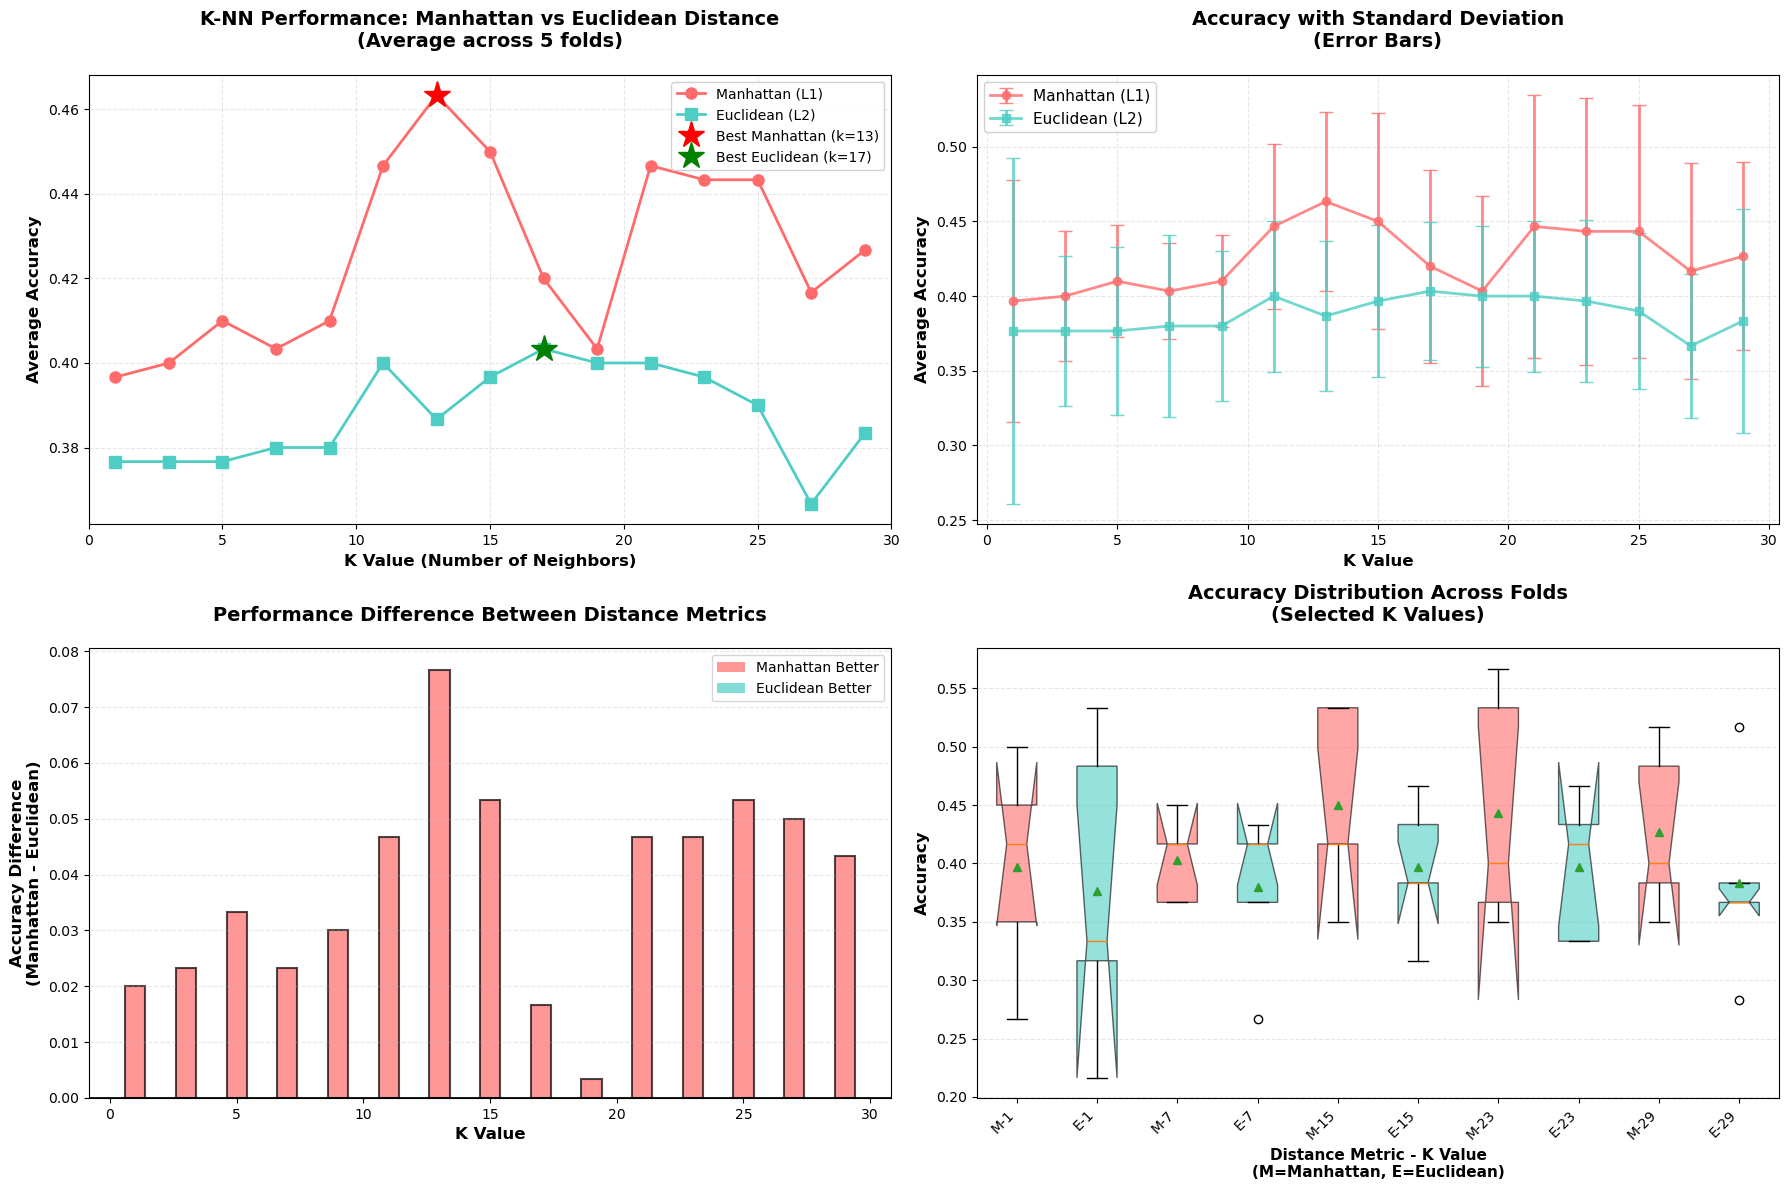

In [16]:
def plot_accuracy_comparison(k_values, avg_acc_manhattan, avg_acc_euclidean, 
                            results_manhattan, results_euclidean):
    fig = plt.figure(figsize=(18, 12))
    ax1 = plt.subplot(2, 2, 1)
    ax1.plot(k_values, [avg_acc_manhattan[k] for k in k_values], 
             marker='o', linewidth=2, markersize=8, 
             label='Manhattan (L1)', color='#FF6B6B', linestyle='-')
    ax1.plot(k_values, [avg_acc_euclidean[k] for k in k_values], 
             marker='s', linewidth=2, markersize=8, 
             label='Euclidean (L2)', color='#4ECDC4', linestyle='-')
    
    ax1.set_xlabel('K Value (Number of Neighbors)', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Average Accuracy', fontsize=12, fontweight='bold')
    ax1.set_title('K-NN Performance: Manhattan vs Euclidean Distance\n(Average across 5 folds)', 
                  fontsize=14, fontweight='bold', pad=20)
    ax1.legend(fontsize=11, loc='best', framealpha=0.9)
    ax1.grid(True, alpha=0.3, linestyle='--')
    ax1.set_xlim(min(k_values) - 1, max(k_values) + 1)
    best_k_manhattan = max(avg_acc_manhattan, key=avg_acc_manhattan.get)
    best_k_euclidean = max(avg_acc_euclidean, key=avg_acc_euclidean.get)
    
    ax1.plot(best_k_manhattan, avg_acc_manhattan[best_k_manhattan], 
             'r*', markersize=20, label=f'Best Manhattan (k={best_k_manhattan})')
    ax1.plot(best_k_euclidean, avg_acc_euclidean[best_k_euclidean], 
             'g*', markersize=20, label=f'Best Euclidean (k={best_k_euclidean})')
    ax1.legend(fontsize=10, loc='best', framealpha=0.9)
    
    # Plot 2
    ax2 = plt.subplot(2, 2, 2)
    manhattan_stds = [np.std(results_manhattan[k]) for k in k_values]
    euclidean_stds = [np.std(results_euclidean[k]) for k in k_values]
    
    ax2.errorbar(k_values, [avg_acc_manhattan[k] for k in k_values], 
                yerr=manhattan_stds, marker='o', linewidth=2, 
                markersize=6, label='Manhattan (L1)', color='#FF6B6B', 
                capsize=5, alpha=0.8)
    ax2.errorbar(k_values, [avg_acc_euclidean[k] for k in k_values], 
                yerr=euclidean_stds, marker='s', linewidth=2, 
                markersize=6, label='Euclidean (L2)', color='#4ECDC4', 
                capsize=5, alpha=0.8)
    
    ax2.set_xlabel('K Value', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Average Accuracy', fontsize=12, fontweight='bold')
    ax2.set_title('Accuracy with Standard Deviation\n(Error Bars)', 
                  fontsize=14, fontweight='bold', pad=20)
    ax2.legend(fontsize=11, loc='best', framealpha=0.9)
    ax2.grid(True, alpha=0.3, linestyle='--')
    
    # Plot 3: Accuracy difference
    ax3 = plt.subplot(2, 2, 3)
    diff = [avg_acc_manhattan[k] - avg_acc_euclidean[k] for k in k_values]
    colors = ['#FF6B6B' if d > 0 else '#4ECDC4' for d in diff]
    
    ax3.bar(k_values, diff, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
    ax3.axhline(y=0, color='black', linestyle='-', linewidth=2)
    ax3.set_xlabel('K Value', fontsize=12, fontweight='bold')
    ax3.set_ylabel('Accuracy Difference\n(Manhattan - Euclidean)', fontsize=12, fontweight='bold')
    ax3.set_title('Performance Difference Between Distance Metrics', 
                  fontsize=14, fontweight='bold', pad=20)
    ax3.grid(True, alpha=0.3, linestyle='--', axis='y')

    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor='#FF6B6B', alpha=0.7, label='Manhattan Better'),
                      Patch(facecolor='#4ECDC4', alpha=0.7, label='Euclidean Better')]
    ax3.legend(handles=legend_elements, fontsize=10, loc='best')
    
    # Plot 4: Box plot for each fold
    ax4 = plt.subplot(2, 2, 4)
    selected_k = [k_values[0], k_values[len(k_values)//4], 
                  k_values[len(k_values)//2], k_values[3*len(k_values)//4], 
                  k_values[-1]]
    
    data_to_plot = []
    labels_to_plot = []
    
    for k in selected_k:
        data_to_plot.append(results_manhattan[k])
        labels_to_plot.append(f'M-{k}')
        data_to_plot.append(results_euclidean[k])
        labels_to_plot.append(f'E-{k}')
    
    bp = ax4.boxplot(data_to_plot, labels=labels_to_plot, patch_artist=True,
                     notch=True, showmeans=True)
    
    for i, patch in enumerate(bp['boxes']):
        if i % 2 == 0:
            patch.set_facecolor('#FF6B6B')
            patch.set_alpha(0.6)
        else:
            patch.set_facecolor('#4ECDC4')
            patch.set_alpha(0.6)
    
    ax4.set_xlabel('Distance Metric - K Value\n(M=Manhattan, E=Euclidean)', 
                   fontsize=11, fontweight='bold')
    ax4.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
    ax4.set_title('Accuracy Distribution Across Folds\n(Selected K Values)', 
                  fontsize=14, fontweight='bold', pad=20)
    ax4.grid(True, alpha=0.3, linestyle='--', axis='y')
    plt.xticks(rotation=45, ha='right')
    
    plt.tight_layout()
    plt.savefig('knn_comparison_detailed.png', dpi=300, bbox_inches='tight')
    print("Plot saved as 'knn_comparison_detailed.png'")
    plt.show()

plot_accuracy_comparison(k_values, avg_accuracies_manhattan, avgAccuraciesEuclidean,
                        results_manhattan, resultsEuclidean)

# Statistical Analysis

In [21]:
def print_statistical_summary(k_values, results_manhattan, resultsEuclidean,
                             avg_acc_manhattan, avgAccEuclidean):
    print("COMPREHENSIVE STATISTICAL SUMMARY")
    print("="*80 + "\n")
    print("1. OVERALL PERFORMANCE METRICS")
    print("-" * 80)
    
    # Manhattan
    all_manhattan_acc = [acc for accs in results_manhattan.values() for acc in accs]
    print(f"\nManhattan (L1) Distance:")
    print(f"  Mean Accuracy (all k, all folds): {np.mean(all_manhattan_acc):.4f}")
    print(f"  Std Deviation: {np.std(all_manhattan_acc):.4f}")
    print(f"  Min Accuracy: {np.min(all_manhattan_acc):.4f}")
    print(f"  Max Accuracy: {np.max(all_manhattan_acc):.4f}")
    print(f"  Best K: {max(avg_acc_manhattan, key=avg_acc_manhattan.get)}")
    print(f"  Best K Accuracy: {avg_acc_manhattan[max(avg_acc_manhattan, key=avg_acc_manhattan.get)]:.4f}")
    
    # Euclidean
    all_euclidean_acc = [acc for accs in resultsEuclidean.values() for acc in accs]
    print(f"\nEuclidean (L2) Distance:")
    print(f"  Mean Accuracy (all k, all folds): {np.mean(all_euclidean_acc):.4f}")
    print(f"  Std Deviation: {np.std(all_euclidean_acc):.4f}")
    print(f"  Min Accuracy: {np.min(all_euclidean_acc):.4f}")
    print(f"  Max Accuracy: {np.max(all_euclidean_acc):.4f}")
    print(f"  Best K: {max(avgAccEuclidean, key=avgAccEuclidean.get)}")
    print(f"  Best K Accuracy: {avgAccEuclidean[max(avgAccEuclidean, key=avgAccEuclidean.get)]:.4f}")
    
    # Comparison
    print(f"\n2. COMPARATIVE ANALYSIS")
    print("-" * 80)
    
    manhattan_wins = sum(1 for k in k_values if avg_acc_manhattan[k] > avgAccEuclidean[k])
    euclidean_wins = sum(1 for k in k_values if avgAccEuclidean[k] > avg_acc_manhattan[k])
    ties = len(k_values) - manhattan_wins - euclidean_wins
    
    print(f"\nPerformance across K values:")
    print(f"  Manhattan wins: {manhattan_wins}/{len(k_values)} ({100*manhattan_wins/len(k_values):.1f}%)")
    print(f"  Euclidean wins: {euclidean_wins}/{len(k_values)} ({100*euclidean_wins/len(k_values):.1f}%)")
    print(f"  Ties: {ties}/{len(k_values)} ({100*ties/len(k_values):.1f}%)")
    
    avg_diff = np.mean([avg_acc_manhattan[k] - avgAccEuclidean[k] for k in k_values])
    print(f"\nAverage accuracy difference (Manhattan - Euclidean): {avg_diff:.4f}")
    
    # Top 5 K values for each metric
    print(f"\n3. TOP 5 K VALUES FOR EACH DISTANCE METRIC")
    print("-" * 80)
    
    print("\nManhattan Distance:")
    sorted_manhattan = sorted(avg_acc_manhattan.items(), key=lambda x: x[1], reverse=True)
    for i, (k, acc) in enumerate(sorted_manhattan[:5], 1):
        print(f"  {i}. K={k}: {acc:.4f}")
    
    print("\nEuclidean Distance:")
    sorted_euclidean = sorted(avgAccEuclidean.items(), key=lambda x: x[1], reverse=True)
    for i, (k, acc) in enumerate(sorted_euclidean[:5], 1):
        print(f"  {i}. K={k}: {acc:.4f}")
    
    print(f"\n4. STABILITY ANALYSIS (Variance Across Folds)")
    print("-" * 80)
    
    manhattan_variances = [np.var(results_manhattan[k]) for k in k_values]
    euclidean_variances = [np.var(resultsEuclidean[k]) for k in k_values]
    print(f"\nAverage variance across all K values:")
    print(f"  Manhattan: {np.mean(manhattan_variances):.6f}")
    print(f"  Euclidean: {np.mean(euclidean_variances):.6f}")
    most_stable_manhattan = k_values[np.argmin(manhattan_variances)]
    most_stable_euclidean = k_values[np.argmin(euclidean_variances)]
    print(f"\nMost stable K value (lowest variance):")
    print(f"  Manhattan: K={most_stable_manhattan} (var={min(manhattan_variances):.6f})")
    print(f"  Euclidean: K={most_stable_euclidean} (var={min(euclidean_variances):.6f})")